In [64]:
import calendar
import glob
import os
import locale
import numpy as np
import pandas as pd
import pickle as pkl

from datetime import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm

In [52]:
sits_coreg_proportion = []

submits_dir = '/home/andresf/workspace/DeepGlobe-Road-Extraction-Challenge/submits/'

for fold in [1, 2, 3, 4, 5]:

    submit_paths = sorted(glob.glob(f'{submits_dir}/dlinknet34-imagenet-gillam-all-season-fold-000{fold}-*/'))

    for submit_path in tqdm(submit_paths):

        with open(os.path.join(submit_path, 'warp_matrices.pkl'), 'rb') as file:
            df = pkl.load(file)

        df['Image'] = ['_'.join(image.split('_')[:-1]) for image in df['Image']]
        df['Month'] = [datetime.strptime(basename.split('_')[-2], '%Y-%m-%d-%H-%M-%S').date().month for basename in df['Image']]

        sits_coreg_proportion.append(df.groupby(['Month']).agg({'Success': ['sum']})['Success']['sum'].values / df.groupby(['Month']).size().reset_index(name='Count')['Count'].values)

print(np.mean(sits_coreg_proportion, axis=0))
print(np.std(sits_coreg_proportion, axis=0))

# data_dir = '/home/andresf/workspace/DeepGlobe-Road-Extraction-Challenge/submits/dlinknet34-imagenet-gillam-all-season-fold-0001-221210-042747/'
# 
# with open(os.path.join(data_dir, 'warp_matrices.pkl'), 'rb') as file:
#     df = pkl.load(file)
# 
# df['Image'] = ['_'.join(image.split('_')[:-1]) for image in df['Image']]
# df['Month'] = [datetime.strptime(basename.split('_')[-2], '%Y-%m-%d-%H-%M-%S').date().month for basename in df['Image']]
# 
# sits_coreg_proportion = df.groupby(['Month']).agg({'Success': ['sum']})['Success']['sum'].values / df.groupby(['Month']).size().reset_index(name='Count')['Count'].values

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 116.99it/s]

[0.95105163 0.96954926 0.98460339 0.97210175 0.98181325 0.98056342
 0.99505706 0.99348276 0.98097835 0.97804531 0.95075696 0.97437148]
[0.05981767 0.03749473 0.02244034 0.02190839 0.01700964 0.02433441
 0.01069739 0.0131444  0.02598696 0.02872838 0.04243104 0.03212103]


In [54]:
data_dir = '/home/andresf/data/northern-cities/gillam_mb_canada/folds/S2_10m_deshifted/'

images = [os.path.splitext(os.path.basename(path))[0] for path in glob.glob(os.path.join(data_dir, '*.tif'))]

with open(os.path.join(data_dir, 'warp_matrices.pkl'), 'rb') as file:
    df = pkl.load(file)

success_images = df['Image'].values.tolist()
success_matrices = df['Warp Matrix'].values.tolist()
success_flags = [True for _ in range(len(df['Image']))]

failure_images = [image for image in images if image not in df['Image'].values.tolist()]
failure_matrices = [np.eye(2, 3, dtype=np.float32) for image in images if image not in df['Image'].values.tolist()]
failure_flags = [False for image in images if image not in df['Image'].values.tolist()]

all_images = success_images + failure_images
all_matrices = success_matrices + failure_matrices
all_flags = [int(flag) for flag in success_flags + failure_flags]
all_months = [datetime.strptime(basename.split('_')[-2], '%Y-%m-%d-%H-%M-%S').date().month for basename in all_images]

df = pd.DataFrame([(image, matrix, flag, month) for image, matrix, flag, month in zip(all_images, all_matrices, all_flags, all_months)],
                  columns=['Image', 'Warp Matrix', 'Success', 'Month'])

baseline_proportion = df.groupby(['Month']).agg({'Success': ['sum']})['Success']['sum'].values / df.groupby(['Month']).size().reset_index(name='Count')['Count'].values

print(baseline_proportion)

[0.93457944 0.92904656 0.94377764 0.94168591 0.95719844 0.96767241
 0.62703252 0.82432432 0.84664537 0.92023634 0.93103448 0.93396226]


In [55]:
locale.setlocale(locale.LC_ALL, ('en_CA', 'UTF-8'))
calendar_months = list(calendar.month_abbr)[1:]

success_proportion = {'Ours': {'mean': np.mean(sits_coreg_proportion, axis=0),
                               'std': np.std(sits_coreg_proportion, axis=0)},
                      'Baseline': baseline_proportion}

/tmp/ipykernel_1207431/1363044988.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'mean' in measurement:


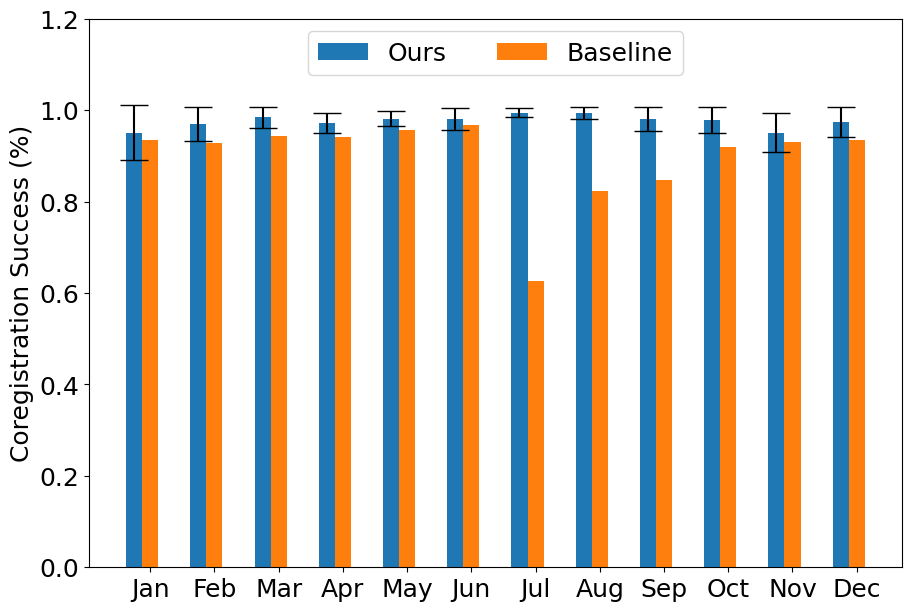

In [63]:
x = np.arange(len(calendar_months))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9, 6))

for attribute, measurement in success_proportion.items():
    offset = width * multiplier
    if 'mean' in measurement:
        rects = ax.bar(x + offset, measurement['mean'], width, yerr=measurement['std'], align='center', ecolor='black', capsize=10, label=attribute)
    else:
        rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Coregistration Success (%)')
ax.set_xticks(x + width, calendar_months)
ax.legend(loc='upper center', ncol=2, fontsize=18)
ax.set_ylim(0, 1.2)

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)

ax.tick_params(axis='both', labelsize=18)

fig.savefig('coreg_success.png')

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 23.21it/s]


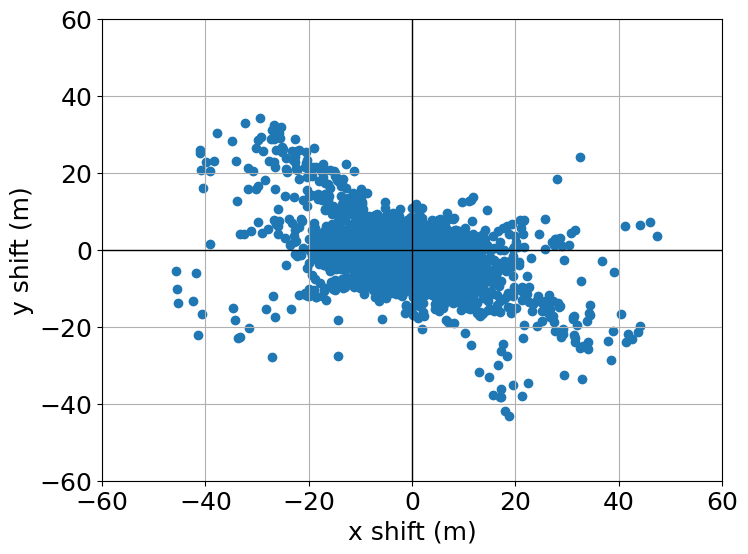

In [71]:
folds_dir = '/home/andresf/data/northern-cities/gillam_mb_canada/folds'
submits_dir = '/home/andresf/workspace/DeepGlobe-Road-Extraction-Challenge/submits/'

x = []
y = []

for fold in [1, 2, 3, 4, 5]:

    fold_images = glob.glob(f'{folds_dir}/fold-000{fold}/test/*_mask.png')
    test_images = ['_'.join(os.path.basename(image).split('_')[:-1]) for image in fold_images]

    submit_paths = sorted(glob.glob(f'{submits_dir}/dlinknet34-imagenet-gillam-all-season-fold-000{fold}-*/'))

    for submit_path in tqdm(submit_paths):

        with open(os.path.join(submit_path, 'warp_matrices.pkl'), 'rb') as file:
            df = pkl.load(file)

        x.extend([df.values[:, 2][idx][0, 2] * 2500 / 1024 for idx in range(df.shape[0])])
        y.extend([df.values[:, 2][idx][1, 2] * 2500 / 1024 for idx in range(df.shape[0])])

#     dff = dfd[dfd['Image'].isin(test_images)]

#     xx = [dff.values[:, 1][idx][0, 2] * 2500 / 1024 for idx in range(dff.shape[0])]
#     yy = [dff.values[:, 1][idx][1, 2] * 2500 / 1024 for idx in range(dff.shape[0])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

ax.scatter(x, y)

ax.set_xlabel('x shift (m)')
ax.set_ylabel('y shift (m)')

ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])

ax.grid()

ax.axhline(y=0, lw=1, color='k')
ax.axvline(x=0, lw=1, color='k')

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)

ax.tick_params(axis='both', labelsize=18)

fig.savefig(f'coreg_ours.png')

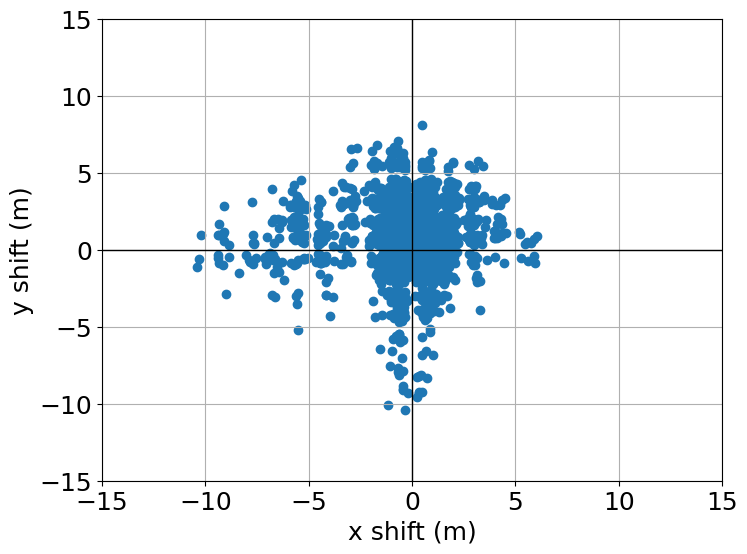

In [70]:
data_dir = '/home/andresf/data/northern-cities/gillam_mb_canada/folds/S2_10m_deshifted/'

with open(os.path.join(data_dir, 'warp_matrices.pkl'), 'rb') as file:
    df = pkl.load(file)

xx = [df.values[:, 1][idx][0, 2] * 2500 / 1024 for idx in range(df.shape[0])]
yy = [df.values[:, 1][idx][1, 2] * 2500 / 1024 for idx in range(df.shape[0])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

ax.scatter(xx, yy)

ax.set_xlabel('x shift (m)')
ax.set_ylabel('y shift (m)')

ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])

ax.grid()

ax.axhline(y=0, lw=1, color='black')
ax.axvline(x=0, lw=1, color='black')

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)

ax.tick_params(axis='both', labelsize=18)

fig.savefig(f'coreg_base.png')

In [ ]:
data_dir = '/home/andresf/data/northern-cities/gillam_mb_canada/folds/S2_10m_deshifted/'

with open(os.path.join(data_dir, 'warp_matrices.pkl'), 'rb') as file:
    dfd = pkl.load(file)

folds_dir = '/home/andresf/data/northern-cities/gillam_mb_canada/folds'

for fold in [1, 2, 3, 4, 5]:

    fold_images = glob.glob(f'{folds_dir}/fold-000{fold}/test/*_mask.png')
    test_images = ['_'.join(os.path.basename(image).split('_')[:-1]) for image in fold_images]

    dff = dfd[dfd['Image'].isin(test_images)]

    xx = [dff.values[:, 1][idx][0, 2] * 2500 / 1024 for idx in range(dff.shape[0])]
    yy = [dff.values[:, 1][idx][1, 2] * 2500 / 1024 for idx in range(dff.shape[0])]

    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.scatter(xx, yy)

    ax.set_xlabel('x shift (m)')
    ax.set_ylabel('y shift (m)')

    ax.set_xlim([-50, 50])
    ax.set_ylim([-50, 50])

    ax.grid()

    ax.axhline(y=0, lw=1, color='k')
    ax.axvline(x=0, lw=1, color='k')
    
    fig.savefig(f'coreg_base_fold-000{fold}.png')